# AMA563 Project1 
## XU, Jiahao 21042344G



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

###0. Load data and The First Taste of Dataset

In [2]:
train = pd.read_csv('train.csv').drop('Id', axis = 1)
# Remove some noise.
train = train.drop(train[train['LotFrontage'] > 200].index)
train = train.drop(train[train['LotArea'] > 100000].index)
train = train.drop(train[train['BsmtFinSF1'] > 4000].index)
train = train.drop(train[train['TotalBsmtSF'] > 5000].index)
train = train.drop(train[train['GrLivArea'] > 4000].index)
train.reset_index(drop=True, inplace=True)
test = pd.read_csv('test.csv').drop('Id', axis = 1)
train_label = train['SalePrice']

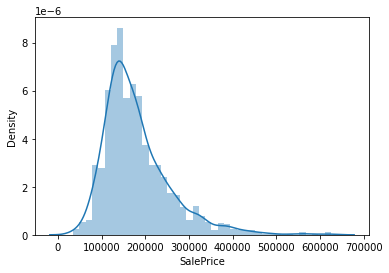

In [3]:
#distribution of SalePrice
sns.distplot(train['SalePrice'])

In [4]:
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.580304
Kurtosis: 3.967127


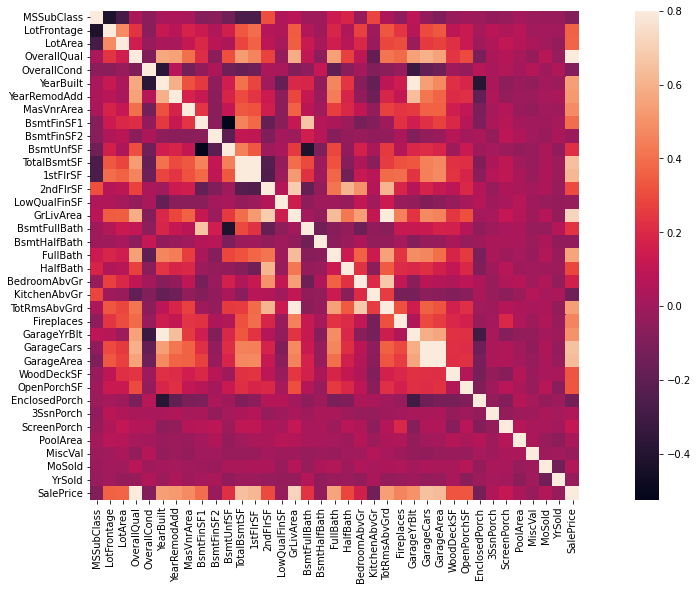

In [5]:
# corr matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=0.8, square=True)

In [6]:
# Combining train and test datasets together so that we can do all the work at once. 
all_data = pd.concat((train, test)).reset_index(drop = True)
# Dropping the target variable. 
all_data.drop(['SalePrice'], axis = 1, inplace = True)

### 1. MasVnrArea Imputation

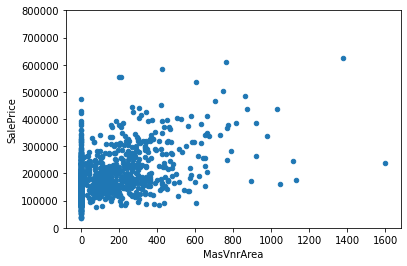

In [7]:
# scatter plot of MasVnrArea
var  = 'MasVnrArea'
train.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

In [8]:
# the top10 features which relative to MasVnrArea
print(all_data.corr()['MasVnrArea'].sort_values(ascending=False)[0:10])

MasVnrArea      1.000000
OverallQual     0.428058
GrLivArea       0.389875
TotalBsmtSF     0.386292
1stFlrSF        0.385320
GarageArea      0.368910
GarageCars      0.360505
YearBuilt       0.313812
BsmtFinSF1      0.291107
TotRmsAbvGrd    0.271420
Name: MasVnrArea, dtype: float64


In [9]:
# First we fill null value in the features we will use later.
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna(all_data['TotalBsmtSF'].mean())
all_data['GarageArea'] = all_data['GarageArea'].fillna(all_data['GarageArea'].mean())
all_data['GarageCars'] = all_data['GarageCars'].fillna(all_data['GarageCars'].mean())

In [10]:
#Feature 
data_is_null = all_data[np.isnan(all_data['MasVnrArea'])]
data_null_index = data_is_null.index
Rela_data_is_null = data_is_null[['OverallQual', 'GrLivArea','TotalBsmtSF','1stFlrSF','GarageArea','GarageCars']]
Rela_data = all_data[['OverallQual', 'GrLivArea','TotalBsmtSF','1stFlrSF','GarageArea','GarageCars']]
Rela_label = all_data['MasVnrArea']
Rela_data = Rela_data.drop(data_null_index)
Rela_label = Rela_label.drop(data_null_index)

In [11]:
# Linear Regressor model
LR = LinearRegression()
LR_Model = LR.fit(Rela_data, Rela_label)
target_prediction = LR_Model.predict(Rela_data_is_null)

In [12]:
# Put prediciton into all_data
j = 0
for i in range(len(all_data)):
    if np.isnan(all_data['MasVnrArea'][i]):
        all_data['MasVnrArea'][i] = target_prediction[j]
        j = j + 1

### 2. GarageQual Imputation with Greedy Target Encoding

In [13]:
# Use 'No' to instead NAN
all_data['GarageQual'] = all_data['GarageQual'].fillna('No')

In [14]:
List = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'No']
Sum_number = []
for item in List:
    count = []
    for i in range(len(all_data)):
        if all_data['GarageQual'][i] == item and i < len(train_label):
            count.append(train_label[i])
#     print(item, sum(count)/len(count))
    Sum_number.append((sum(count), len(count)))

In [15]:
a = 0.1
p = train_label.mean()
Target_encoding = []
for item in Sum_number:
    Target_encoding.append((item[0]+a*p)/ (item[1]+a))

In [16]:
i = 0
for item in List:
    for j in range(len(all_data['GarageQual'])):
        if all_data['GarageQual'][j] == item:
            all_data['GarageQual'][j] = Target_encoding[i]
    i = i + 1
all_data['GarageQual'] = pd.DataFrame(all_data['GarageQual'],dtype=np.float)

### 3. Other features imputation

In [17]:
missing_val_col = ["Alley", 
                   "PoolQC", 
                   "MiscFeature",
                   "Fence",
                   "FireplaceQu",
                   "GarageType",
                   "GarageFinish",
                   "GarageCond",
                   'BsmtQual',
                   'BsmtCond',
                   'BsmtExposure',
                   'BsmtFinType1',
                   'BsmtFinType2',
                   'MasVnrType']

for i in missing_val_col:
    all_data[i] = all_data[i].fillna('None')

In [18]:
missing_val_col2 = ['BsmtFinSF1',
                    'BsmtFinSF2',
                    'BsmtUnfSF',
                    'BsmtFullBath', 
                    'BsmtHalfBath', 
                    'GarageYrBlt']

for i in missing_val_col2:
    all_data[i] = all_data[i].fillna(0)

In [19]:
# Use the bin of 'Neighborhood' to fill the null in 'LotFrontage
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform( lambda x: x.fillna(x.mean()))

In [20]:
# change the data type of 'MSSubClass'
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
# use mode to fill
all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
# change the data type of 'YrSold'
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

all_data['Functional'] = all_data['Functional'].fillna('Typ') 
all_data['Utilities'] = all_data['Utilities'].fillna('AllPub') 
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0]) 
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna("TA") 
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna("SBrkr") 

### 4. Feature generation

In [21]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['YrBltAndRemod'] = all_data['YearBuilt'] + all_data['YearRemodAdd']
all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] 
                                 + all_data['BsmtFinSF2'] 
                                 + all_data['1stFlrSF'] 
                                 + all_data['2ndFlrSF']
                                )
all_data['Total_Bathrooms'] = (all_data['FullBath'] 
                               + (0.5 * all_data['HalfBath']) 
                               + all_data['BsmtFullBath'] 
                               + (0.5 * all_data['BsmtHalfBath'])
                              )
                               

all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] 
                              + all_data['3SsnPorch'] 
                              + all_data['EnclosedPorch'] 
                              + all_data['ScreenPorch'] 
                              + all_data['WoodDeckSF']
                             )
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [22]:
all_data = all_data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

In [23]:

numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_feats[abs(skewed_feats) > 0.5]
# high_skew
for feature in high_skew.index:
    # all_data[feature] = np.log1p(all_data[feature])
    # print(feature)
    if feature != 'GarageYrBlt':
    
      all_data[feature] = boxcox1p(all_data[feature], boxcox_normmax(all_data[feature] + 1))
    else:
      all_data[feature] = np.log1p(all_data[feature])



### 5. PCA

In [24]:
train_data = all_data[:1460]
train_data['SalePrice'] = train_label

In [25]:
train_data.shape

(1460, 87)

In [26]:
train_data.corr()['SalePrice'].sort_values(ascending=False)[:11]

SalePrice            1.000000
OverallQual          0.802764
TotalSF              0.796275
Total_sqr_footage    0.711844
GrLivArea            0.701209
GarageCars           0.650491
GarageArea           0.638346
TotalBsmtSF          0.634947
Total_Bathrooms      0.634223
YrBltAndRemod        0.594128
1stFlrSF             0.593753
Name: SalePrice, dtype: float64

In [27]:
# use the top 10 features to do PCA so that get more useful features.
high_rela_features = ['OverallQual','TotalSF','GrLivArea', 'Total_sqr_footage', 'GarageCars', 'Total_Bathrooms', 'GarageArea','TotalBsmtSF', '1stFlrSF', 'YrBltAndRemod']
high_rela_features_set = all_data[high_rela_features]

pca = PCA(0.95)
pca_data_set = pca.fit_transform(high_rela_features_set)

In [28]:
pca_data_set.shape

(2910, 2)

In [29]:
# pca_new_features = pd.DataFrame(pca_data_set, 
#                    columns=['pca_one','pca_two','pca_three'])
pca_new_features = pd.DataFrame(pca_data_set, 
                   columns=['pca_one','pca_two'])

In [30]:
all_data['pca_one'] = pca_new_features['pca_one']
all_data['pca_two'] = pca_new_features['pca_two']
# all_data['pca_three'] = pca_new_features['pca_three']

### 6. Dummies

In [31]:
print('Now, the shape of all_data is %s'%(str(all_data.shape)))
all_data_dummies = pd.get_dummies(all_data)
print('After dummies,  the shape of all_data is %s'%(str(all_data_dummies.shape)))

Now, the shape of all_data is (2910, 88)
After dummies,  the shape of all_data is (2910, 330)


### 7. Train our Model

In [32]:
# give a valid set first, we take 20% tuple in train.
train_data = all_data_dummies[:1168]
valid_data = all_data_dummies[1168:len(train)]
test_data = all_data_dummies[len(train):]

train_label = train['SalePrice'][:1168]
valid_label = train['SalePrice'][1168:]

In [33]:
# # Apply log to our train set
# train_data_log = np.log1p(train_data)
# test_data_log = np.log1p(test_data)
# valid_data_log = np.log1p(valid_data)

In [34]:
train_data

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,TotalSF,YrBltAndRemod,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,...,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,27.386771,33.810743,7,3.987225,2.579085e+51,2003,19.870628,144.831397,0.000000,30.057145,425.584315,6.012004,1139.606967,0.000000,9.058086,0.994662,0.000000,2,1.068745,3,0.750944,2.261492,0.000000,7.602900,2.0,548.0,3.924670e+21,0.000000,12.065731,0.000000,0.0,0.000000,0.000000,0.000000,39.432748,4006,13.103725,3.5,18.741880,0.000000,...,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,31.991469,35.024543,6,5.991815,2.077759e+51,1976,0.000000,182.673379,0.000000,44.248103,598.537304,6.315821,0.000000,0.000000,8.617471,0.000000,0.708758,2,0.000000,3,0.750944,1.996206,0.903025,7.589336,2.0,460.0,3.924670e+21,56.638583,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,39.195924,3952,12.906539,2.5,51.659106,0.000000,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,28.328981,36.587743,7,3.987225,2.538375e+51,2002,18.151243,110.950181,0.000000,57.055340,453.419487,6.068741,1156.419436,0.000000,9.121723,0.994662,0.000000,2,1.068745,3,0.750944,1.996206,0.903025,7.601902,2.0,608.0,3.924670e+21,0.000000,9.890390,0.000000,0.0,0.000000,0.000000,0.000000,40.204157,4003,12.943377,3.5,14.658663,0.000000,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,25.789724,34.974112,7,3.987225,1.260983e+51,1970,0.000000,62.035224,0.000000,64.997788,381.570108,6.102982,1002.760589,0.000000,9.064058,0.994662,0.000000,1,0.000000,3,0.750944,2.136944,0.903025,7.600402,3.0,642.0,3.924670e+21,0.000000,8.956977,16.051222,0.0,0.000000,0.000000,0.000000,38.904828,3885,12.527536,2.0,52.633711,0.000000,...,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,33.178341,39.041934,8,3.987225,2.518247e+51,2000,26.054373,137.291650,0.000000,61.341309,549.510227,6.240051,1419.827620,0.000000,9.427460,0.994662,0.000000,2,1.068745,4,0.750944,2.373229,0.903025,7.601402,3.0,836.0,3.924670e+21,42.555177,14.252745,0.000000,0.0,0.000000,0.000000,0.000000,43.415697,4000,13.543714,3.5,49.227394,0.000000,...,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,30.788363,35.303362,6,4.673954,2.094569e+51,1977,0.000000,116.760886,0.000000,67.403695,528.797864,6.221428,0.000000,0.000000,8.443675,0.994662,0.000000,1,0.000000,3,0.750944,1.996206,0.903025,7.589842,1.0,358.0,3.924670e+21,44.130371,0.000000,0.000000,0.0,0.000000,5.256878,0.000000,37.361860,3954,12.112987,2.0,40.555598,41.797413,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1164,30.788363,34.531989,6,4.673954,1.795974e+51,1958,0.000000,138.336425,0.000000,69.134904,598.120701,6.315205,0.000000,0.000000,8.616331,0.9

#### 7.1 XGBOOST

In [53]:
xgb_reg = xgb.XGBRegressor(colsample_bytree = 0.1, learning_rate = 0.08,
                max_depth = 4, alpha = 1, n_estimators = 1500, random_state = 10)
xgb_reg.fit(train_data,np.log1p(train_label))
valid_prediciton = xgb_reg.predict(valid_data)
mse = metrics.mean_squared_error(np.expm1(valid_prediciton), valid_label)
print('the RMSE of XGBOOST is %s'%(np.sqrt(mse)))

[04:53:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
the RMSE of XGBOOST is 19595.14381715123


#### 7.2 LightGBM

In [54]:
lgbm = lgb.LGBMRegressor(learning_rate = 0.085, random_state = 10, n_estimators = 450, max_depth = 5) ####4444444
lgbm.fit(train_data,np.log1p(train_label))
valid_prediciton = lgbm.predict(valid_data)
mse = metrics.mean_squared_error(np.expm1(valid_prediciton), valid_label)
print('the RMSE of LightGBM is %s'%(np.sqrt(mse)))

the RMSE of LightGBM is 21751.79136736162


### 8. Give output Submission

In [58]:
prediciton = xgb_reg.predict(test_data)
df_predction = pd.DataFrame(np.expm1(prediciton))
df_predction.columns= ['SalePrice']
df_predction.head()
X1 = pd.concat([pd.read_csv('test.csv')['Id'], df_predction], axis = 1)
X1.to_csv('Submission_XGBOOST.csv', index=False)

X1

,Id,SalePrice
0,1461,118481.765625
1,1462,164186.171875
2,1463,194199.468750
3,1464,206934.781250
4,1465,189003.062500
...,...,...
1454,2915,83472.140625
1455,2916,77695.296875
1456,2917,166195.406250
1457,2918,115852.625000


In [59]:
prediciton = lgbm.predict(test_data)
df_predction = pd.DataFrame(np.expm1(prediciton))
df_predction.columns= ['SalePrice']
df_predction.head()
X2 = pd.concat([pd.read_csv('test.csv')['Id'], df_predction], axis = 1)
X2.to_csv('Submission_LightGBM.csv', index=False)

X2

,Id,SalePrice
0,1461,126880.237896
1,1462,163917.005706
2,1463,185148.412917
3,1464,193417.017250
4,1465,191940.737965
...,...,...
1454,2915,80660.726979
1455,2916,79275.968313
1456,2917,165282.498939
1457,2918,112730.457014


In [60]:
X = X1
X['Id'] = X1['Id']
X['SalePrice'] = (X1['SalePrice']+X2['SalePrice'])/2
# X['SalePrice'] = X['SalePrice']/2
X.to_csv('Submission_FinalModel.csv', index=False)

X

,Id,SalePrice
0,1461,122681.001761
1,1462,164051.588791
2,1463,189673.940834
3,1464,200175.899250
4,1465,190471.900232
...,...,...
1454,2915,82066.433802
1455,2916,78485.632594
1456,2917,165738.952595
1457,2918,114291.541007


### 9. Importance

#### 9.1 XGBOOST

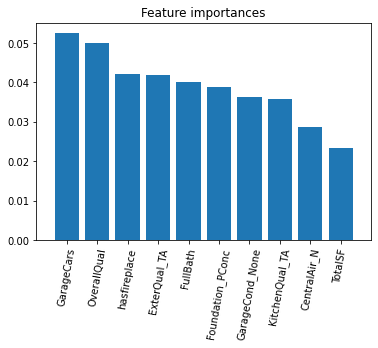

In [61]:
features = list(train_data.columns)
importances = xgb_reg.feature_importances_
indices = np.argsort(importances)[::-1][:10]
num_features = 10
#
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation = '80')
plt.xlim([-1, num_features])
plt.savefig('XGBOOST.png', dpi = 600,bbox_inches='tight')
plt.show()

#### 9.2 LightGBM

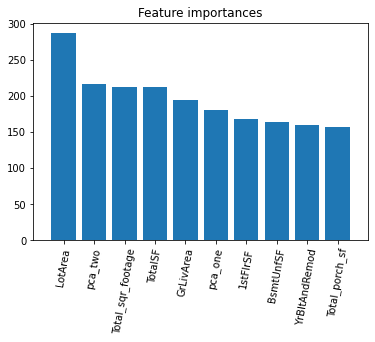

In [62]:
features = list(train_data.columns)
importances = lgbm.feature_importances_
indices = np.argsort(importances)[::-1][:10]
num_features = 10
#
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation = '80')
plt.xlim([-1, num_features])
plt.savefig('LightGBM.png', dpi = 600,bbox_inches='tight')
plt.show()